In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Splitting

The dataset contains information for many different cities and so I will split the data into two seperate subsets. One of these subsets will contain data for Rio de Janeiro, the other will contain data for Sao Paulo.

These two datasets will then be used to compare model performances.

In [ ]:
data = pd.read_csv("sudeste.csv")

rio = data[data['city'] == 'Rio de Janeiro']
rio.set_index('mdct', inplace=True)
rio.index = pd.to_datetime(rio.index)
rio = rio[rio.index.year == 2015]
rio = rio[rio['wsnm'] == 'MARAMBAIA']

sp = data[data['city'] == 'São Paulo']
sp.set_index('mdct', inplace=True)
sp.index = pd.to_datetime(sp.index)
sp = sp[sp.index.year == 2015]

## Data Investigation

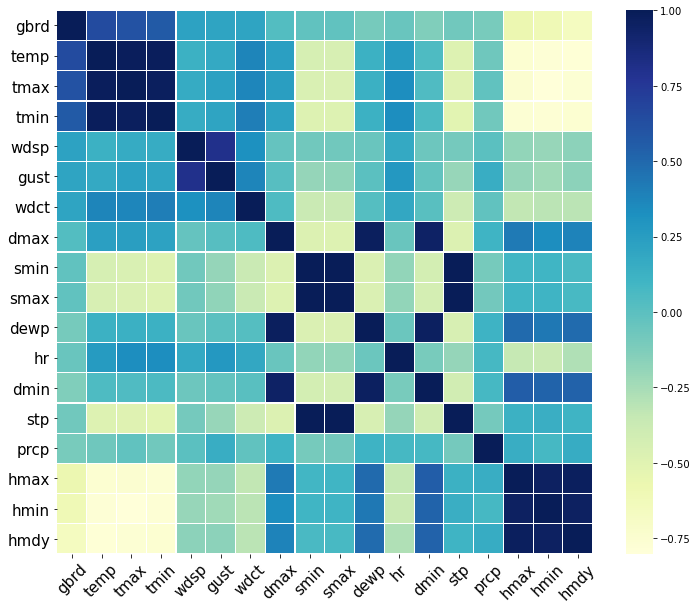

In [28]:
def heatmap(data):
    k = 21 #number of variables for heatmap
    corrmat = sp.corr(method='spearman')
    cols = corrmat.nlargest(k, 'gbrd')['gbrd'].index
    cm = np.corrcoef(sp[cols].values.T)
    f, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(cm, ax=ax, cmap="YlGnBu", linewidths=0.1, yticklabels=cols.values, xticklabels=cols.values)
    plt.xticks(fontsize = 15, rotation = 45)
    plt.yticks(fontsize = 15, rotation = 0)
    plt.show()
    
heatmap(data)

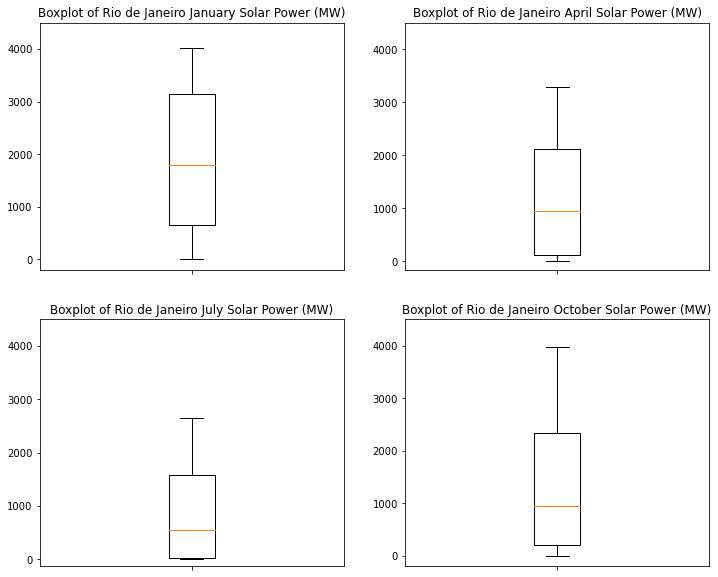

In [10]:
def boxplots(data):   
    
    plt.figure(figsize = (12,10))
    plt.subplot(221)
    plt.boxplot(rio_jan["gbrd"])
    plt.title("Boxplot of Rio de Janeiro January Solar Power (MW)")
    plt.xticks([1], [''])
    plt.ylim(top = 4500)
    plt.subplot(222)
    plt.boxplot(rio_apr["gbrd"])
    plt.title("Boxplot of Rio de Janeiro April Solar Power (MW)")
    plt.xticks([1], [''])
    plt.ylim(top = 4500)
    plt.subplot(223)
    plt.boxplot(rio_jul["gbrd"])
    plt.title("Boxplot of Rio de Janeiro July Solar Power (MW)")
    plt.xticks([1], [''])
    plt.ylim(top = 4500)
    plt.subplot(224)
    plt.boxplot(rio_oct["gbrd"])
    plt.title("Boxplot of Rio de Janeiro October Solar Power (MW)")
    plt.xticks([1], [''])
    plt.ylim(top = 4500)
    plt.show()
    
boxplots(data)

Function for comparing monthly averages for two columns graphically

In [ ]:
def monthly_comparison(rio_data, sp_data):
    
    rio_monthly = rio_data.groupby(rio['mo'])
    sp_monthly = sp_data.groupby(sp['mo'])
    rio_monthly_mean = rio_monthly.mean()
    sp_monthly_mean = sp_monthly.mean()

    plt.figure()
    rio_monthly_mean.plot(color='red', figsize=[8,5], label = 'Rio de Janeiro')
    sp_monthly_mean.plot(color='blue', label = 'São Paulo')
    plt.legend()
    plt.show
    
monthly_comparison(rio['gbrd'], sp['gbrd'])

## Feature Selection and Engineering

The following columns don't add any information to any models as the function of them is for identification purposes of the weather station and hence for the one station the values are the same throughout. Because of this they will all be dropped. This leaves us with 17 predictor variables and one target variable.

In [4]:
rio = rio.drop(['wsid','wsnm','elvt','lat','lon','inme','city','prov','date','yr','mo','da'], axis = 1)
sp = sp.drop(['wsid','wsnm','elvt','lat','lon','inme','city','prov','date','yr','mo','da'], axis = 1)

After analysing the precipitation column it is clear that when there was no precipitation, NaN was filled in instead of zero and so it is justified to replace the NaN's for both datasets with zero's.

For both the wind speed and gust columns occasionally there are NaN's. It makes sense that each observation is highly correlated with the prior observation and so it makes sense to interpolate these values linearly.

In [5]:
rio['prcp'] = rio['prcp'].fillna(0)
sp['prcp'] = sp['prcp'].fillna(0)

rio['gust'].interpolate('linear', inplace=True, limit_direction='both')
rio['wdsp'].interpolate('linear', inplace=True, limit_direction='both')
sp['gust'].interpolate('linear', inplace=True, limit_direction='both')
sp['wdsp'].interpolate('linear', inplace=True, limit_direction='both')

rio = rio[rio['gbrd'].notna()]
sp = sp[sp['gbrd'].notna()]

A quick analysis of the 'gbrd' columns in both datasets shows us that between the hours of 11 p.m. and 9 a.m. there was no recording for solar power taken. This trend should result in 3650 Na's for the dataset as it is a full year and by checking the sum of the Na's for both datasets we can see that this is exactly the amount present, therefore no other Na's exist and it is fair to remove these hours from the dataset.

In [7]:
print("Na's present in Rio dataset")
print(rio.isna().sum())
print("")
print("Na's present in São Paulo dataset")
print(sp.isna().sum())

Na's present in Rio dataset
hr      0
prcp    0
stp     0
smax    0
smin    0
gbrd    0
temp    0
dewp    0
tmax    0
dmax    0
tmin    0
dmin    0
hmdy    0
hmax    0
hmin    0
wdsp    0
wdct    0
gust    0
dtype: int64

Na's present in São Paulo dataset
hr      0
prcp    0
stp     0
smax    0
smin    0
gbrd    0
temp    0
dewp    0
tmax    0
dmax    0
tmin    0
dmin    0
hmdy    0
hmax    0
hmin    0
wdsp    0
wdct    0
gust    0
dtype: int64


## Machine Learning Models

In [6]:
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from statistics import mean 
from math import sqrt

Dividing the dataset into different months

In [7]:
rio_jan = rio[rio.index.month == 1]
rio_apr = rio[rio.index.month == 4]
rio_jul = rio[rio.index.month == 7]
rio_oct = rio[rio.index.month == 10]

In [8]:
sp_jan = sp[sp.index.month == 1]
sp_apr = sp[sp.index.month == 4]
sp_jul = sp[sp.index.month == 7]
sp_oct = sp[sp.index.month == 10]

**LINEAR REGRESSION**

In [186]:
def lin_reg(data, testing_size):
    
    X = data.drop('gbrd', axis=1).values
    y = data['gbrd'].values
    

    
    if testing_size == 1:
        test_size = float(14 / len(X))
    elif testing_size == 3:
        test_size = float(42 / len(X))
    elif testing_size == 5:
        test_size = float(70 / len(X))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
    
    model = LinearRegression(fit_intercept = 1)
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    
    print('rmse = %.3f' %(rmse))


**RIDGE REGRESSION**

In [237]:
def ridge(data, testing_size):
    
    X = data.drop('gbrd', axis=1).values
    y = data['gbrd'].values

    if testing_size == 1:
        test_size = float(14 / len(X))
    elif testing_size == 3:
        test_size = float(42 / len(X))
    elif testing_size == 5:
        test_size = float(70 / len(X))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)

    alpha = 0
    alphas = {}
    for i in range(1001):
        model = Ridge(alpha = alpha)
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_test)
        rmse = sqrt(mean_squared_error(y_test, y_pred))

        alphas[alpha] = rmse
        alpha += 0.05
    
    lowest_rmse = 0
    best_alpha = 0
    for k,v in alphas.items():
        
        if lowest_rmse == 0:
            lowest_rmse = v
            best_alpha = k
        
        elif lowest_rmse > v:
            lowest_rmse = v
            best_alpha = k

    print('alpha = %.2f, rmse = %.3f' %(best_alpha, lowest_rmse))


**SUPPORT VECTOR REGRESSION**

In [19]:
def svr(data, testing_size):
    
    X = data.drop('gbrd', axis=1).values
    y = data['gbrd'].values

    if testing_size == 1:
        test_size = float(14 / len(X))
    elif testing_size == 3:
        test_size = float(42 / len(X))
    elif testing_size == 5:
        test_size = float(70 / len(X))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
    
    model = SVR(kernel = 'linear')
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))

    print('rmse = %.3f' %(rmse))


**STOCHASTIC GRADIENT DESCENT**

In [301]:
def sgd(data, testing_size):
    X = data.drop('gbrd', axis=1).values
    y = data['gbrd'].values
    

    
    if testing_size == 1:
        test_size = float(14 / len(X))
    elif testing_size == 3:
        test_size = float(42 / len(X))
    elif testing_size == 5:
        test_size = float(70 / len(X))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
    
    scores = []
    for i in range(10000):
        model = SGDRegressor(loss = 'huber')
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_test)
        
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        scores.append(rmse)
        
    print('rmse = %.3f' %(mean(scores)))


**K NEIGHBOURS REGRESSION**

In [304]:
def knr(data, testing_size):
    X = data.drop('gbrd', axis=1).values
    y = data['gbrd'].values
    
    ss = StandardScaler()
    X = ss.fit_transform(X)
    
    if testing_size == 1:
        test_size = float(14 / len(X))
    elif testing_size == 3:
        test_size = float(42 / len(X))
    elif testing_size == 5:
        test_size = float(70 / len(X))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
    
    neighbors = {}
    for neigh in range(1,11):
        model = KNeighborsRegressor(n_neighbors = neigh)
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_test)
    
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        neighbors[neigh] = rmse
    
    lowest_rmse = 0
    best_neigh = 0
    for k,v in neighbors.items():
        
        if lowest_rmse == 0:
            lowest_rmse = v
            best_neigh = k
        
        elif lowest_rmse > v:
            lowest_rmse = v
            best_neigh = k
            
    print('neighbours = %d, rmse = %.3f' %(best_neigh, lowest_rmse))

**DECISION TREES**

In [269]:
def dt(data, testing_size):
    X = data.drop('gbrd', axis=1).values
    y = data['gbrd'].values
    

    
    if testing_size == 1:
        test_size = float(14 / len(X))
    elif testing_size == 3:
        test_size = float(42 / len(X))
    elif testing_size == 5:
        test_size = float(70 / len(X))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
    
    
    min_samp = 2
    min_samples = {}
    for i in range(50):
        model = DecisionTreeRegressor(min_samples_split = min_samp)
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_test)
        
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        min_samples[min_samp] = rmse
        min_samp += 1
    
    lowest_rmse = 0
    best_sample = 0
    for k,v in min_samples.items():
        
        if lowest_rmse == 0:
            lowest_rmse = v
            best_sample = k
        
        elif lowest_rmse > v:
            lowest_rmse = v
            best_sample = k
            
    print('min split = %d, rmse = %.3f' %(best_sample, lowest_rmse))
    

**RANDOM FOREST**

In [24]:
def rf(data, testing_size):
    X = data.drop('gbrd', axis=1).values
    y = data['gbrd'].values
    
    if testing_size == 1:
        test_size = float(14 / len(X))
    elif testing_size == 3:
        test_size = float(42 / len(X))
    elif testing_size == 5:
        test_size = float(70 / len(X))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
    
    model = RandomForestRegressor()
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)
        
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    
        
    print('rmse = %.3f' %(rmse))